<a href="https://colab.research.google.com/github/Abhiroop2004/Mask-Secret/blob/main/WatchTower_Insight_CVHackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision in Secret Sharing
### A Hackathon Submission for **INSIGHT**

- Team Name -  `WatchTower`
- Leader Name - `Abhiroop Sarkar`
- Track - `Safety and Security`


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Image Instance Segmentation using Mask-RCNN

### Importing Libraries

In [ ]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import torch, torchvision
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

###  Importing Data

### Custom Dataset Training

In [ ]:
import xml.etree.ElementTree as ET

class CustomDataset(Dataset):
    def __init__(self, img_dir, annot_dir, transforms=None):
        self.img_dir = img_dir
        self.annot_dir = annot_dir
        self.transforms = transforms
        self.image_files = sorted(os.listdir(img_dir))  # Sort the images to maintain consistency

    def parse_voc_xml(self, filename):
        # Parse the XML annotation file
        tree = ET.parse(filename)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall('object'):
            label = obj.find('name').text  # Get the object label

            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])  # Append bounding box coordinates
            labels.append(1)  # You can assign labels based on your dataset (e.g., class ID 1 for all)

        #print(boxes, labels, "\n")

        return boxes, labels

    def __getitem__(self, idx):
        # Load image
        img_filename = self.image_files[idx]
        #print(f"Loading image: {img_filename}")
        img_path = os.path.join(self.img_dir, img_filename)
        img = Image.open(img_path).convert("RGB")

        # Load and parse annotation
        annot_filename = img_filename.replace('.png', '.xml')  # Assuming XML files match image filenames
        #print(f"Loading annotation: {annot_filename}")
        annot_path = os.path.join(self.annot_dir, annot_filename)
        boxes, labels = self.parse_voc_xml(annot_path)

        # Convert boxes and labels to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Dummy masks, as we don't have real ones
        masks = torch.ones((len(boxes), img.size[1], img.size[0]), dtype=torch.uint8)

        # Prepare target dictionary
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['masks'] = masks

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_files)

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())  # Convert PIL images to tensors
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

"""# Usage
img_dir = 'images'  # Path to your images folder
annot_dir = 'annotations'  # Path to your annotations folder

# Define dataset
dataset = CustomDataset(img_dir=img_dir, annot_dir=annot_dir, transforms=get_transform(train=True))
dataset_test = CustomDataset(img_dir=img_dir, annot_dir=annot_dir, transforms=get_transform(train=False))"""

"# Usage\nimg_dir = 'images'  # Path to your images folder\nannot_dir = 'annotations'  # Path to your annotations folder\n\n# Define dataset\ndataset = CustomDataset(img_dir=img_dir, annot_dir=annot_dir, transforms=get_transform(train=True))\ndataset_test = CustomDataset(img_dir=img_dir, annot_dir=annot_dir, transforms=get_transform(train=False))"

In [ ]:
def evaluate(model, data_loader, device):
    model.eval()
    total_iou = 0
    count = 0

    with torch.no_grad():
        for images, targets in data_loader:
            # Move images and targets to the device
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Get model predictions
            outputs = model(images)

            # Optionally log or process outputs
            for i, output in enumerate(outputs):
                pred_boxes = output['boxes'].cpu().numpy()
                pred_labels = output['labels'].cpu().numpy()
                pred_scores = output['scores'].cpu().numpy()
                pred_masks = output['masks'].cpu().numpy()

                true_boxes = targets[i]['boxes'].cpu().numpy()
                true_labels = targets[i]['labels'].cpu().numpy()

                # Example: calculate IoU between predicted and ground truth boxes
                iou = calculate_mean_iou(pred_boxes, true_boxes)
                total_iou += iou
                count += 1

                # Optionally: visualize or save predictions
                # visualize_predictions(images[i], pred_boxes, pred_labels, pred_masks)

        # Print or log the average IoU over the dataset
        print(f"Average IoU: {total_iou / count:.4f}")

# Example IoU calculation function
def calculate_mean_iou(pred_boxes, true_boxes, threshold=0.5):
    def iou(boxA, boxB):
        # Compute intersection area
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

        # Compute union area
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
        unionArea = float(boxAArea + boxBArea - interArea)

        return interArea / unionArea

    # Compute IoU for all pairs of predicted and true boxes
    ious = []
    for pred_box in pred_boxes:
        for true_box in true_boxes:
            ious.append(iou(pred_box, true_box))

    # Return the mean IoU (optional: use thresholding)
    ious = [i for i in ious if i >= threshold]
    return np.mean(ious) if ious else 0.0

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

def get_model(num_classes):
    # Load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one (change number of classes for your dataset)
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    return model

def train_model():
    dataset = CustomDataset(img_dir=r'/content/drive/MyDrive/Data/images', annot_dir=r'/content/drive/MyDrive/Data/annotations', transforms=get_transform(train=True))
    dataset_test = CustomDataset(img_dir=r'/content/drive/MyDrive/Data/images', annot_dir=r'/content/drive/MyDrive/Data/annotations', transforms=get_transform(train=False))

    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-40])
    print(f"Train Indices:{dataset}")
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])
    print(f"Test Indices:{dataset_test}")

    data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=collate_fn)
    print ("Train dataset loaded!")
    data_loader_test = DataLoader(dataset_test, batch_size=2, shuffle=False, num_workers=0, collate_fn=collate_fn)
    print ("Test dataset loaded!")

    num_classes = 2

    model = get_model(num_classes)
    device = torch.device('cuda')
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.95, weight_decay=0.0001)  # Reduced lr and weight_decay
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # Decays lr every 3 epochs


    # Training loop
    num_epochs = 20
    print("Training!")
    for epoch in range(num_epochs):
        print(f"Iteration {epoch+1}...")
        # Train for one epoch
        model.train()
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())

            # Backpropagation
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        # Update the learning rate
        lr_scheduler.step()
    print ("Training Complete")
    evaluate(model, data_loader_test, device=device)
    return model


Training the Model

In [ ]:
custom_model = train_model()

Train Indices:<torch.utils.data.dataset.Subset object at 0x7b85a4698e80>
Test Indices:<torch.utils.data.dataset.Subset object at 0x7b84dfc8f970>
Train dataset loaded!
Test dataset loaded!


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 117MB/s]


Training!
Iteration 1...
Iteration 2...
Iteration 3...
Iteration 4...
Iteration 5...
Iteration 6...
Iteration 7...
Iteration 8...
Iteration 9...
Iteration 10...
Iteration 11...
Iteration 12...
Iteration 13...
Iteration 14...
Iteration 15...
Iteration 16...
Iteration 17...
Iteration 18...
Iteration 19...
Iteration 20...
Training Complete
Average IoU: 0.7122


In [ ]:
def predict_and_visualize(model, image_path, device, score_threshold=0.1):
    transform = T.Compose([T.ToTensor(), ])
    image = transform(Image.open(image_path))
    model.eval()
    with torch.no_grad():
        prediction = model([image.to(device)])

    masks = prediction[0]['masks'].cpu().numpy()  # (N, 1, H, W)
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    print(scores, "\n", masks)

    if len(boxes) == 0:
        print("No predictions were made for this image.")
        return

    plt.imshow(Image.open(image_path).convert("RGB"))

    for i in range(len(boxes)):
        if scores[i] > score_threshold:
            mask = masks[i, 0]
            plt.contour(mask, colors='r', linewidths=2)  # Mask contour

            box = boxes[i]
            plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], edgecolor='blue', fill=False, linewidth=2))  # Bounding box
            plt.text(box[0], box[1] - 10, f'{i+1}', color='yellow', fontsize=8, bbox=dict(facecolor='blue', alpha=0.5))  # Text label
    plt.show()

[0.955891   0.5394383  0.11207986] 
 [[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]]


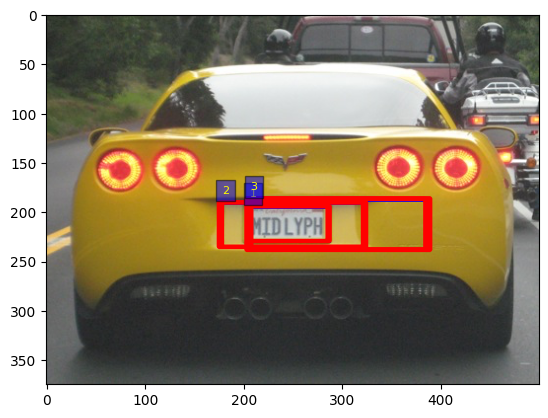

In [ ]:
predict_and_visualize(custom_model, "Cars36.png", device=torch.device('cuda'), score_threshold=0.1)

In [ ]:
import pickle

file_name = "Number_Plate_model_71.pkl"
with open(file_name, 'wb') as file:
    pickle.dump(custom_model, file)